<a href="https://colab.research.google.com/github/Zero00502/Sonar-obj-detector/blob/main/Integrated_Object_Detection_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Preprocessing

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sierra022/sonar-imaging-mine-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8


In [14]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [15]:
import os
import shutil

# Set the base path based on your folder structure
base_path = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8'

# Define paths for the main train directory
train_images_path = os.path.join(base_path, 'train/train/images')
train_labels_path = os.path.join(base_path, 'train/train/labels')

# Ensure the train directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)

# Save the final train path in a variable
final_train_path = os.path.join(base_path, 'train/train')
print(f"Final train folder path: {final_train_path}")


Final train folder path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train


In [16]:
def load_image(image_path):
    """Loads an image, resizes it, and preprocesses it."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (416, 416))  # Resize to YOLO input size
    image = image / 255.0  # Normalize
    return image


In [17]:
def parse_labels(label_path, img_width, img_height):
    """Parses a label file to generate YOLO-compatible labels."""
    yolo_labels = np.zeros((13, 13, 3, 5))  # 13x13 grid, 3 anchors, 5 outputs

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            width = float(values[3]) * img_width
            height = float(values[4]) * img_height

            # Calculate grid cell position
            grid_x = int(x_center // (img_width / 13))
            grid_y = int(y_center // (img_height / 13))

            # Normalize coordinates relative to grid cell
            x_offset = (x_center % (img_width / 13)) / (img_width / 13)
            y_offset = (y_center % (img_height / 13)) / (img_height / 13)
            norm_width = width / img_width
            norm_height = height / img_height

            # Assign to anchor (use the first anchor for simplicity)
            yolo_labels[grid_y, grid_x, 0, :] = [1, x_offset, y_offset, norm_width, norm_height]
    return yolo_labels


In [ ]:
# Example: Load and display one image and its labels
image_path = os.path.join(train_images_path, "0002_2015.jpg")
label_path = os.path.join(train_labels_path, "0002_2015.txt")

# Debugging: Ensure paths are correct
print(f"Image path: {image_path}")
print(f"Label path: {label_path}")

# Load the image and parse the labels
image = load_image(image_path)
img_height, img_width, _ = image.shape
objects = parse_labels(label_path, img_width, img_height)

# Visualize labels on the image
for obj in objects:
    class_id, x1, y1, x2, y2 = obj
    color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"{class_id}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

Image path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images/0002_2015.jpg
Label path: /root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels/0002_2015.txt


ValueError: too many values to unpack (expected 5)

In [18]:
image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
objects_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'

# Prepare data
images = []
labels = []
max_objects = 0

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for image extensions
        image_path = os.path.join(image_dir, filename)
        objects_file = os.path.join(objects_dir, filename[:-4] + '.txt')

        if os.path.exists(objects_file):
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color format
            if img is None:
                raise FileNotFoundError(f"Image file not found or cannot be read: {image_path}")

            # Handle shape based on image type
            if len(img.shape) == 3:
                img_height, img_width, _ = img.shape
            else:
                img_height, img_width = img.shape

            # Parse labels and resize images
            objects = parse_labels(objects_file, img_width, img_height)
            img = cv2.resize(img, (416, 416))  # Resize to consistent size
            images.append(img)
            labels.append(objects)

            # Update max_objects if current image has more annotations
            max_objects = max(max_objects, len(objects))


# Step 2: Binary Classification Model

In [22]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class YOLODataGenerator(Sequence):
    def __init__(self, image_paths, label_paths, batch_size, img_width=416, img_height=416):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = []
        batch_labels = []

        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            if i >= len(self.image_paths):
                break

            # Load and preprocess the image
            image = self.load_image(self.image_paths[i])
            label = self.parse_labels(self.label_paths[i])

            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = cv2.resize(image, (self.img_width, self.img_height))
        return image / 255.0  # Normalize to [0, 1]

    def parse_labels(self, label_path):
        grid_size = 13
        num_anchors = 3
        num_classes = 1  # Assuming binary classification (Mine/No Mine)

        labels = np.zeros((grid_size, grid_size, num_anchors, 5))  # [obj, x, y, w, h]
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())

                # Scale coordinates to grid size
                x_cell = int(x_center * grid_size)
                y_cell = int(y_center * grid_size)

                # Assign label to the corresponding grid cell
                for anchor in range(num_anchors):
                    labels[y_cell, x_cell, anchor, 0] = 1  # Objectness
                    labels[y_cell, x_cell, anchor, 1:5] = [x_center, y_center, width, height]

        return labels


In [ ]:
for images, labels in train_generator:
    preds = detection_model.predict(images)
    print("Image batch shape:", images.shape)  # Should be (batch_size, 416, 416, 3)
    print("Label batch shape:", labels.shape)  # Should be (batch_size, 13, 13, 3, 5)
    print("Prediction shape:", preds.shape)    # Should match (batch_size, 13, 13, 3, 5)
    break



NameError: name 'train_generator' is not defined

# Step 3: Object Detection Model

In [23]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Reshape

# Step 1: Collect image and label paths
train_image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images'
val_image_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/images'
train_label_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels'
val_label_dir = '/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/labels'

# Collect image paths
image_paths_train = [os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.png'))]
image_paths_val = [os.path.join(val_image_dir, f) for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))]

# Collect label paths
label_paths_train = [os.path.join(train_label_dir, f.replace('.jpg', '.txt').replace('.png', '.txt')) for f in os.listdir(train_image_dir) if f.endswith(('.jpg', '.png'))]
label_paths_val = [os.path.join(val_label_dir, f.replace('.jpg', '.txt').replace('.png', '.txt')) for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))]

# Verify paths
assert len(image_paths_train) == len(label_paths_train), "Mismatch in training images and labels"
assert len(image_paths_val) == len(label_paths_val), "Mismatch in validation images and labels"

# Define input
input_layer = Input(shape=(416, 416, 3))

# Downsample the input
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 416 -> 208
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 208 -> 104
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 104 -> 52
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 52 -> 26
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample: 26 -> 13
x = Conv2D(5 * 3, (1, 1), activation="linear")(x)  # 5 values (obj + bbox) * 3 anchors

# Reshape the output to YOLO format
output_layer = Reshape((13, 13, 3, 5))(x)

# Define the model
detection_model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary to verify output shape
detection_model.summary()


import tensorflow as tf

def yolo_loss(y_true, y_pred):
    # Objectness loss (binary cross-entropy)
    obj_true = y_true[..., 0]  # Shape: (batch_size, 13, 13, 3)
    obj_pred = y_pred[..., 0]  # Shape: (batch_size, 13, 13, 3)
    obj_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(obj_true, obj_pred))

    # Bounding box loss (mean squared error)
    bbox_true = y_true[..., 1:5]  # Shape: (batch_size, 13, 13, 3, 4)
    bbox_pred = y_pred[..., 1:5]  # Shape: (batch_size, 13, 13, 3, 4)
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred))

    # Combine losses
    total_loss = obj_loss + bbox_loss
    return total_loss

detection_model.compile(optimizer="adam", loss=yolo_loss)

# Initialize the data generators
train_generator = YOLODataGenerator(
    image_paths=image_paths_train,
    label_paths=label_paths_train,
    batch_size=32,
    img_width=416,
    img_height=416
)

val_generator = YOLODataGenerator(
    image_paths=image_paths_val,
    label_paths=label_paths_val,
    batch_size=32,
    img_width=416,
    img_height=416
)

# Train the model
detection_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 416, 416, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 208, 208, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 208, 208, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 104, 104, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 104, 104, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 13, 13, 15)          │           3,855 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 13, 13, 3, 5)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,463 (1.51 MB)

 Trainable params: 396,463 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 699ms/step - loss: 0.0549 - val_loss: 0.0505
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 390ms/step - loss: 0.0571 - val_loss: 0.0504
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0000e+00
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step - loss: 0.0557 - val_loss: 0.0504
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0000e+00
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - loss: 0.0569 - val_loss: 0.0504
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0000e+00
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - loss: 0.0572 - val_loss: 0.0504
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0000e+00
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - loss: 0.0653 - val_loss: 0.0504
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.0000e+00
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - loss: 0.0572 - val_loss: 0.0504
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0000e+00
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - los

# Step 4: Validation and Visualization

In [33]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Randomly pick an image from the dataset
def pick_random_image(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No images found in the directory.")
    return os.path.join(image_dir, random.choice(image_files))

# Load label file and convert to bounding box coordinates
def load_label(label_path, img_width, img_height):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            box_width = float(values[3]) * img_width
            box_height = float(values[4]) * img_height

            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            labels.append([class_id, x1, y1, x2, y2])
    return labels

# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

# Visualize detections and ground truth
def visualize_detections(image_path, predictions, ground_truths, class_labels, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Draw predicted boxes
    for prediction in predictions:
        class_id, confidence, x_center, y_center, box_width, box_height = prediction
        if confidence < confidence_threshold:
            continue

        x1 = int((x_center - box_width / 2) * width)
        y1 = int((y_center - box_height / 2) * height)
        x2 = int((x_center + box_width / 2) * width)
        y2 = int((y_center + box_height / 2) * height)

        color = (0, 255, 0)  # Green for predictions
        label = f"{class_labels[class_id]} ({confidence:.2f})"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw ground truth boxes
    for truth in ground_truths:
        class_id, x1, y1, x2, y2 = truth
        color = (255, 0, 0)  # Red for ground truth
        x = 0
        label = f"{x+1}"
        #label = f"Ground Truth: {[class_id]}"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Main function for validation
image_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/images"
label_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/val/val/labels"
class_labels = {0: "Mine"}  # Add more classes as needed

# Randomly pick an image and its label
random_image_path = pick_random_image(image_dir)
label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(random_image_path))[0] + ".txt")

# Load and preprocess the image
test_image = load_image(random_image_path)
test_image_batch = np.expand_dims(test_image, axis=0)

# Predict bounding boxes
predictions = detection_model.predict(test_image_batch)[0]
processed_predictions = postprocess_predictions(predictions)

# Load ground truth labels
ground_truths = load_label(label_path, img_width=416, img_height=416)

# Visualize predictions and ground truth
visualize_detections(random_image_path, processed_predictions, ground_truths, class_labels)

# Validate predictions against ground truth using IoU
for ground_truth in ground_truths:
    gt_box = ground_truth[1:]  # Extract bounding box coordinates
    for prediction in processed_predictions:
        pred_box = [
            int((prediction[2] - prediction[4] / 2) * 416),
            int((prediction[3] - prediction[5] / 2) * 416),
            int((prediction[2] + prediction[4] / 2) * 416),
            int((prediction[3] + prediction[5] / 2) * 416),
        ]
        iou = calculate_iou(gt_box, pred_box)
        print(f"IoU between GT box {gt_box} and Pred box {pred_box}: {iou:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


TypeError: postprocess_predictions() missing 2 required positional arguments: 'img_width' and 'img_height'

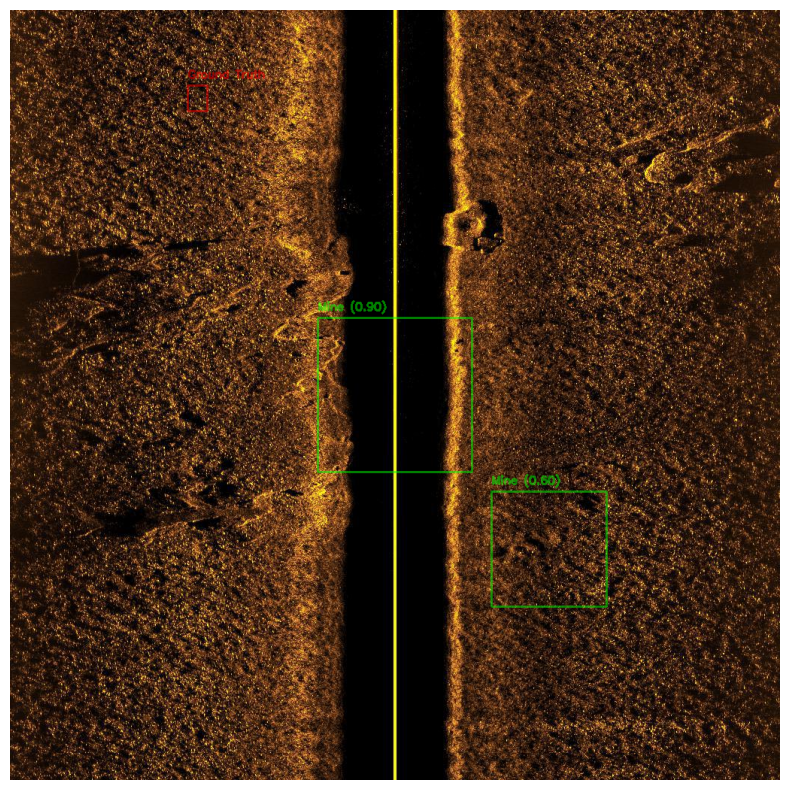

IoU between GT box [236, 100, 262, 134] and Pred box [166, 166, 249, 249]: 0.00
IoU between GT box [236, 100, 262, 134] and Pred box [260, 260, 322, 322]: 0.00


In [30]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Randomly pick an image from the dataset
def pick_random_image(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No images found in the directory.")
    return os.path.join(image_dir, random.choice(image_files))

# Load label file and convert to bounding box coordinates
def load_label(label_path, img_width, img_height):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            box_width = float(values[3]) * img_width
            box_height = float(values[4]) * img_height

            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            labels.append([class_id, x1, y1, x2, y2])
    return labels

# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

# Visualize detections and ground truths
def visualize_detections(image_path, predictions, ground_truths, class_labels, confidence_threshold=0.5):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    overlay = image.copy()

    # Draw predicted boxes
    for prediction in predictions:
        class_id, confidence, x_center, y_center, box_width, box_height = prediction
        if confidence < confidence_threshold:
            continue

        x1 = int((x_center - box_width / 2) * width)
        y1 = int((y_center - box_height / 2) * height)
        x2 = int((x_center + box_width / 2) * width)
        y2 = int((y_center + box_height / 2) * height)

        color = (0, 255, 0)  # Green for predictions
        label = f"{class_labels.get(class_id, 'Unknown')} ({confidence:.2f})"
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw ground truth boxes
    for truth in ground_truths:
        class_id, x1, y1, x2, y2 = truth
        color = (255, 0, 0)  # Red for ground truth
        label = "Ground Truth"
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Apply transparency
    alpha = 0.5
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Validate predictions and calculate IoU
def validate_predictions(predictions, ground_truths, width, height):
    for truth in ground_truths:
        gt_box = truth[1:]  # Extract ground truth box coordinates
        for prediction in predictions:
            pred_box = [
                int((prediction[2] - prediction[4] / 2) * width),
                int((prediction[3] - prediction[5] / 2) * height),
                int((prediction[2] + prediction[4] / 2) * width),
                int((prediction[3] + prediction[5] / 2) * height),
            ]
            iou = calculate_iou(gt_box, pred_box)
            print(f"IoU between GT box {gt_box} and Pred box {pred_box}: {iou:.2f}")

# Main function for validation
def main():
    image_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images"
    label_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels"
    class_labels = {0: "Mine"}  # Define class labels

    # Randomly pick an image and its label
    random_image_path = pick_random_image(image_dir)
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(random_image_path))[0] + ".txt")

    # Load ground truth labels
    ground_truths = load_label(label_path, img_width=416, img_height=416)

    # Load and preprocess the image
    test_image = cv2.imread(random_image_path)
    if test_image is None:
        raise FileNotFoundError(f"Image not found: {random_image_path}")
    test_image = cv2.resize(test_image, (416, 416))
    test_image = test_image / 255.0
    test_image_batch = np.expand_dims(test_image, axis=0)

    # Mock prediction data for testing (replace with your model predictions)
    predictions = [
        [0, 0.9, 0.5, 0.5, 0.2, 0.2],  # [class_id, confidence, x_center, y_center, box_width, box_height]
        [0, 0.6, 0.7, 0.7, 0.15, 0.15],
    ]

    # Visualize predictions and ground truth
    visualize_detections(random_image_path, predictions, ground_truths, class_labels, confidence_threshold=0.5)

    # Validate predictions with IoU
    validate_predictions(predictions, ground_truths, 416, 416)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


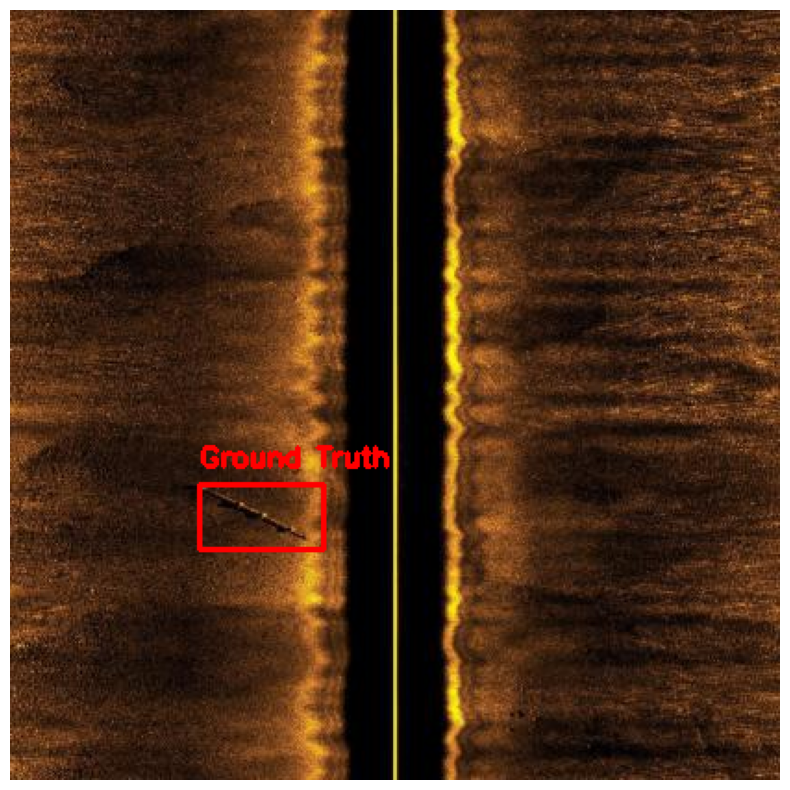

Average IoU: 0.00


In [32]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

# Randomly pick an image from the dataset
def pick_random_image(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        raise FileNotFoundError("No images found in the directory.")
    return os.path.join(image_dir, random.choice(image_files))

# Load label file and convert to bounding box coordinates
def load_label(label_path, img_width, img_height):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            class_id = int(values[0])
            x_center = float(values[1]) * img_width
            y_center = float(values[2]) * img_height
            box_width = float(values[3]) * img_width
            box_height = float(values[4]) * img_height

            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            labels.append([class_id, x1, y1, x2, y2])
    return labels

# Postprocess predictions (decode boxes, confidence threshold, NMS)
def postprocess_predictions(predictions, img_width, img_height, confidence_threshold=0.5, nms_threshold=0.4):
    boxes, confidences, class_ids = [], [], []

    # Flatten predictions for easier processing
    for row in predictions.reshape(-1, 5):
        confidence = row[0]  # Object confidence
        if confidence > confidence_threshold:
            x_center, y_center, width, height = row[1:5]
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            boxes.append([x1, y1, x2, y2])
            confidences.append(float(confidence))
            class_ids.append(0)  # Modify for multi-class models

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
    return [(class_ids[i[0]], confidences[i[0]], *boxes[i[0]]) for i in indices]

# Visualize detections and ground truths
def visualize_detections(image_path, predictions, ground_truths, class_labels):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Draw predicted boxes
    for prediction in predictions:
        class_id, confidence, x1, y1, x2, y2 = prediction
        color = (0, 255, 0)  # Green for predictions
        label = f"{class_labels.get(class_id, 'Unknown')} ({confidence:.2f})"
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw ground truth boxes
    for truth in ground_truths:
        class_id, x1, y1, x2, y2 = truth
        color = (255, 0, 0)  # Red for ground truth
        label = "Ground Truth"
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Validate predictions and calculate IoU
def validate_predictions(predictions, ground_truths):
    total_iou = 0
    for truth in ground_truths:
        gt_box = truth[1:]  # Extract ground truth box coordinates
        for prediction in predictions:
            pred_box = prediction[2:]  # Extract prediction box coordinates
            iou = calculate_iou(gt_box, pred_box)
            total_iou += iou
            print(f"IoU between GT box {gt_box} and Pred box {pred_box}: {iou:.2f}")
    print(f"Average IoU: {total_iou / len(ground_truths):.2f}")

# Calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

# Main function for validation
def main():
    image_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/images"
    label_dir = "/root/.cache/kagglehub/datasets/sierra022/sonar-imaging-mine-detection/versions/8/train/train/labels"
    class_labels = {0: "Mine"}  # Define class labels

    # Randomly pick an image and its label
    random_image_path = pick_random_image(image_dir)
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(random_image_path))[0] + ".txt")

    # Load ground truth labels
    ground_truths = load_label(label_path, img_width=416, img_height=416)

    # Load and preprocess the image
    test_image = cv2.imread(random_image_path)
    if test_image is None:
        raise FileNotFoundError(f"Image not found: {random_image_path}")
    test_image = cv2.resize(test_image, (416, 416)) / 255.0
    test_image_batch = np.expand_dims(test_image, axis=0)

    # Predict bounding boxes
    raw_predictions = detection_model.predict(test_image_batch)[0]
    predictions = postprocess_predictions(raw_predictions, img_width=416, img_height=416)

    # Visualize predictions and ground truths
    visualize_detections(random_image_path, predictions, ground_truths, class_labels)

    # Validate predictions with IoU
    validate_predictions(predictions, ground_truths)

if __name__ == "__main__":
    main()
